# IMPORT LIBRARIS

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Reshape, Resizing, Dense, Conv2D, Flatten, Rescaling, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall, AUC, FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import cv2
%matplotlib inline

# LOAD DATASET

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/human-emotions-datasethes.zip -d /content/dataset

Archive:  /content/human-emotions-datasethes.zip
replace /content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_dir = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ['angry', 'happy', 'sad']

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 128,  # Reduced image size for faster processing (adjust based on dataset complexity)
    "EPOCHS": 30,  # Increased epochs for better convergence
    "LEARNING_RATE": 0.0001,  # Reduced learning rate for more stable training
    "NO_OF_FILTERS": 32,  # Increased filters for better feature extraction
    "KERNEL_SIZE": (3, 3),
    "POOL_SIZE": (2, 2),
    "NO_OF_STRIDES": 1,
    "DROPOUT_RATE": 0.5,  # Added dropout to reduce overfitting
    "DENSE_UNITS_1": 128,  # Increased dense units for better learning capacity
    "DENSE_UNITS_2": 64,  # Intermediate dense layer size
    "REGULARIZATION_RATE": 0.01,  # Added regularization to reduce overfitting
    "ACTIVATION_FUNCTION": "relu",
    "METRICS": [
        CategoricalAccuracy(name="accuracy"),
        TopKCategoricalAccuracy(k=2, name="top_k_accuracy"),
    ],
    "NUM_OF_CLASSES": 3,  # Number of classes in the dataset
}

In [ ]:
train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names= CLASS_NAMES,
    color_mode='rgb',
    batch_size= CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed= 99,
    verbose=True
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical', # if use "int", the loss function is "SparseCategoricalCrossentropy". now the loss functions is  "CategoricalCrossentropy"
    class_names= CLASS_NAMES,
    color_mode='rgb',
    batch_size= CONFIGURATION['BATCH_SIZE'],
    image_size= (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed= 99,
    verbose=True
)

Found 2278 files belonging to 3 classes.


# DATASET VISUALIZATION

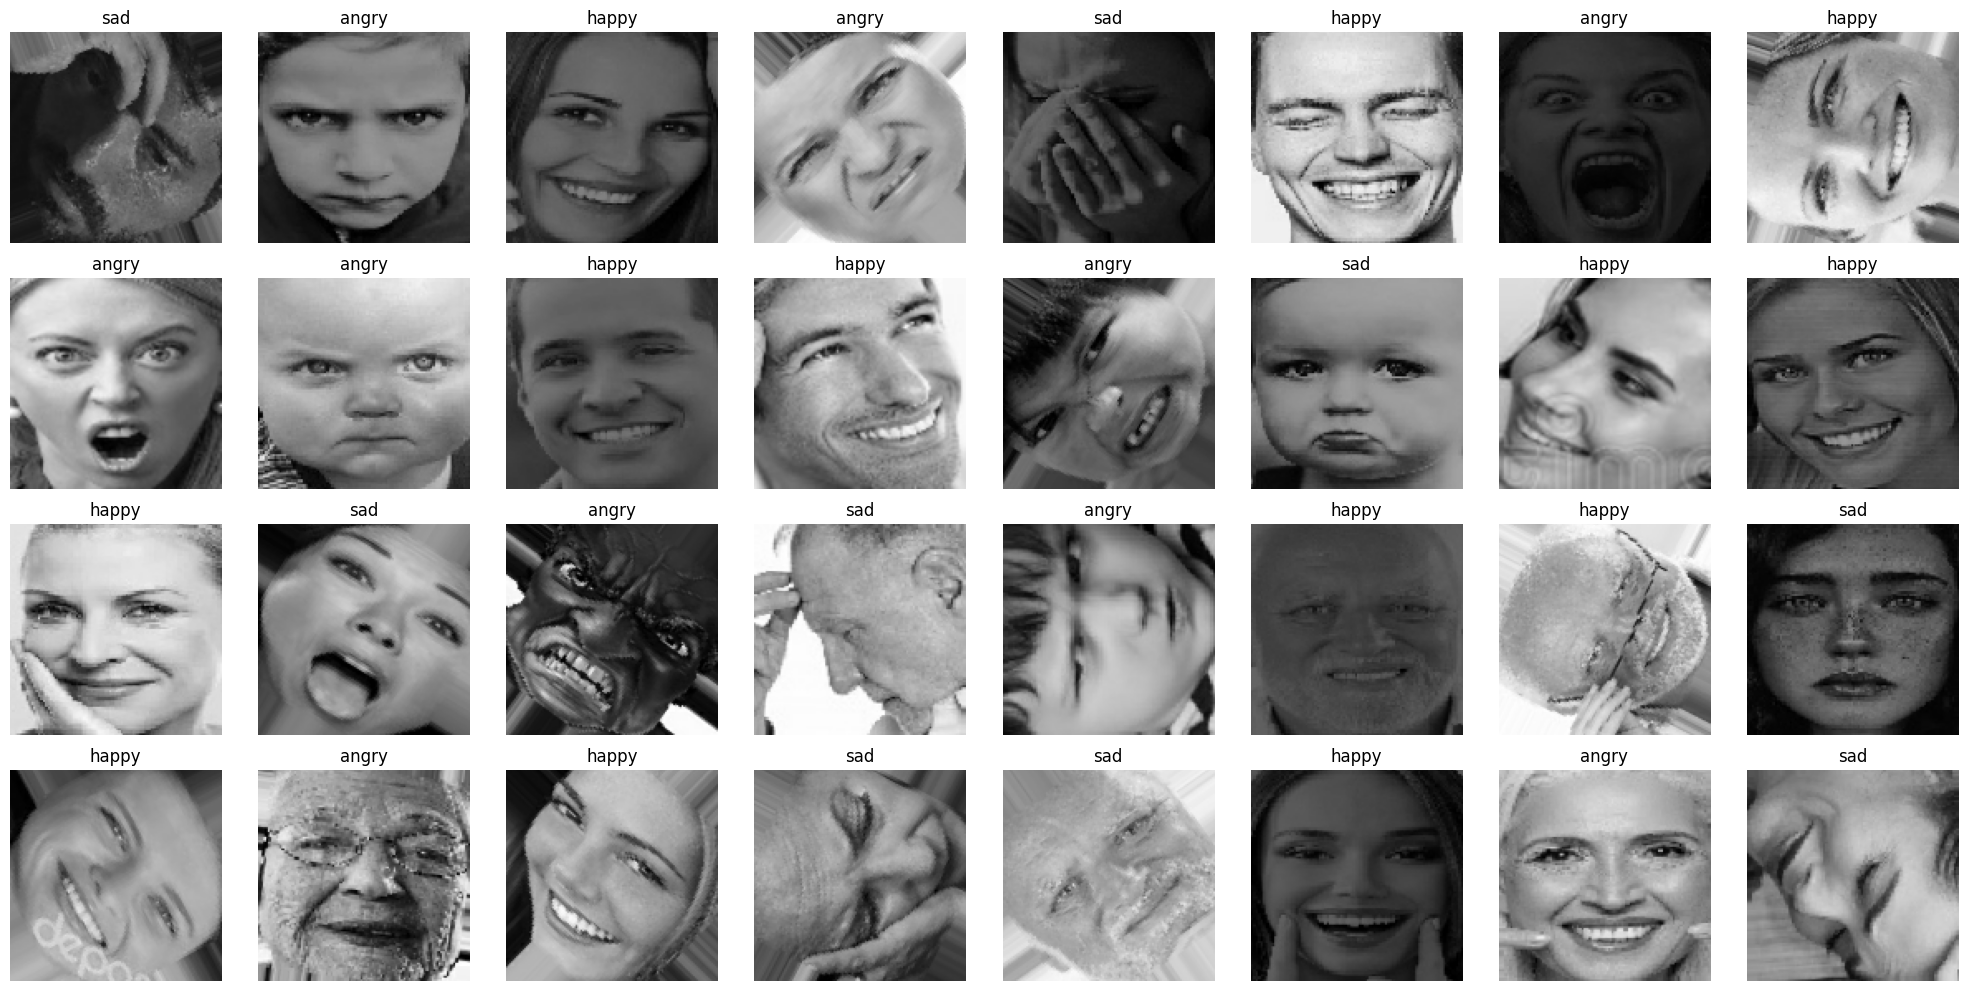

In [ ]:
for images, labels in train_dataset.take(1):
  break
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
  if i < images.shape[0]:
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(CLASS_NAMES[np.argmax(labels[i])])
    ax.axis('off')
  else:
    ax.axis('off')
plt.tight_layout()
plt.show()

# DATA PREPARATION

In [ ]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# MODELING

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
  Rescaling(1./255)
])

In [ ]:
model = Sequential([
    # INPUT LAYER
    InputLayer(input_shape=(None,None, 3), name="Input_Layer"),
    resize_and_rescale,

    # CONVOLUTIONAL BLOCK 1
    Conv2D(filters=CONFIGURATION["NO_OF_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["NO_OF_STRIDES"], activation=CONFIGURATION["ACTIVATION_FUNCTION"],
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]), name="Conv2D_1"),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["NO_OF_STRIDES"] * 2, name="MaxPooling2D_1"),
    Dropout(CONFIGURATION["DROPOUT_RATE"], name="Dropout_1"),  # Prevent overfitting

    # CONVOLUTIONAL BLOCK 2
    Conv2D(filters=CONFIGURATION["NO_OF_FILTERS"] * 2, kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["NO_OF_STRIDES"], activation=CONFIGURATION["ACTIVATION_FUNCTION"],
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]), name="Conv2D_2"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["NO_OF_STRIDES"] * 2, name="MaxPooling2D_2"),
    Dropout(CONFIGURATION["DROPOUT_RATE"], name="Dropout_2"),

    # CONVOLUTIONAL BLOCK 3 (Added an additional layer for better feature extraction)
    Conv2D(filters=CONFIGURATION["NO_OF_FILTERS"] * 4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["NO_OF_STRIDES"], activation=CONFIGURATION["ACTIVATION_FUNCTION"],
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]), name="Conv2D_3"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["NO_OF_STRIDES"] * 2, name="MaxPooling2D_3"),
    Dropout(CONFIGURATION["DROPOUT_RATE"], name="Dropout_3"),

    # FLATTEN LAYER
    Flatten(name="Flatten"),

    # FULLY CONNECTED LAYERS
    Dense(CONFIGURATION["DENSE_UNITS_1"], activation=CONFIGURATION["ACTIVATION_FUNCTION"],
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]), name="Dense_1"),
    BatchNormalization(name="BatchNormalization_4"),
    Dropout(CONFIGURATION["DROPOUT_RATE"], name="Dropout_4"),

    Dense(CONFIGURATION["DENSE_UNITS_2"], activation=CONFIGURATION["ACTIVATION_FUNCTION"],
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]), name="Dense_2"),
    BatchNormalization(name="BatchNormalization_5"),

    # OUTPUT LAYER
    Dense(CONFIGURATION["NUM_OF_CLASSES"], activation="softmax", name="Output_Layer"),
])

In [ ]:
model._name = "Human_Emotions_Detector"

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=CategoricalCrossentropy(),
    metrics=CONFIGURATION['METRICS']
)

In [ ]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNormalization_1                 │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (MaxPooling2D)        │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNormalization_2                 │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (MaxPooling2D)        │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNormalization_3                 │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_3 (MaxPooling2D)        │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNormalization_4                 │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNormalization_5                 │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,314,755 (12.64 MB)

 Trainable params: 3,313,923 (12.64 MB)

 Non-trainable params: 832 (3.25 KB)

# TRAINING

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss to detect overfitting
    patience=5,                # Stop training if val_loss doesn't improve for 5 epochs
    verbose=1,                 # Print when early stopping is triggered
    restore_best_weights=True, # Restore the model weights from the best epoch
    min_delta=0.0001,# Minimum change in val_loss to be considered as improvement
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIGURATION['EPOCHS'],
    verbose=1
)

Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.3865 - loss: 6.1183 - top_k_accuracy: 0.7143 - val_accuracy: 0.2261 - val_loss: 7.6611 - val_top_k_accuracy: 0.6677
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4739 - loss: 5.6466 - top_k_accuracy: 0.7833 - val_accuracy: 0.4412 - val_loss: 7.5601 - val_top_k_accuracy: 0.6677
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5201 - loss: 5.3020 - top_k_accuracy: 0.8066 - val_accuracy: 0.4438 - val_loss: 7.6285 - val_top_k_accuracy: 0.6681
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5549 - loss: 4.9829 - top_k_accuracy: 0.8236 - val_accuracy: 0.4346 - val_loss: 7.2481 - val_top_k_accuracy: 0.6782
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5612 - loss: 4.7054 - top_k_accuracy: 0.8351 - val_accuracy: 0.4526 - val_loss: 7.6949 - val_top_k_accuracy: 0.6835
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5862 - loss: 4.38

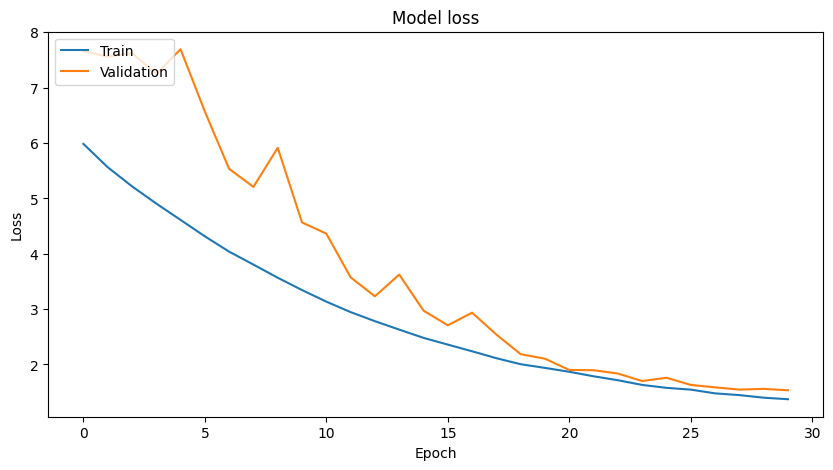

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

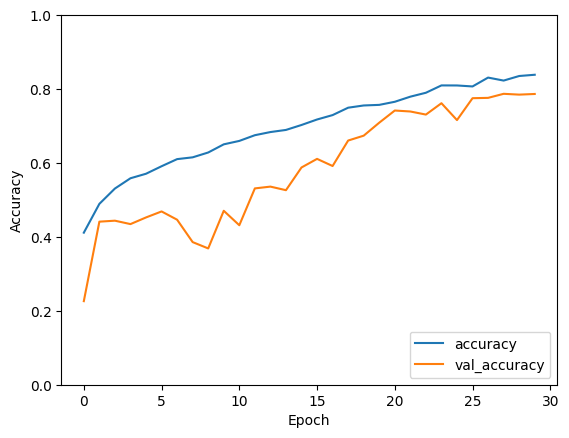

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(val_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7835 - loss: 1.5422 - top_k_accuracy: 0.9265


[1.5338386297225952, 0.7866549491882324, 0.9249341487884521]

# SOME PREDICTIONS

In [ ]:
PATHS = ["/content/sad1.jpg", "/content/sad2.jpg", "/content/sad3.jpg","/content/sad4.jpg", "/content/angry1.jpg", "/content/angry2.jpg", "/content/angry3.jpg", "/content/happy1.jpg", "/content/happy2.jpg", "/content/happy3.jpg"]

In [ ]:
len(PATHS)

10

In [ ]:
imgs = []
predictions = []
for path in PATHS:
  true_im = plt.imread(path)
  im = tf.constant(true_im, dtype=tf.float32)
  im = tf.expand_dims(im, axis=0)
  imgs.append(true_im)
  prediction =np.argmax(model.predict(im))
  if prediction == 0:
    predictions.append("Angry")
  elif prediction == 1:
    predictions.append("Happy")
  else:
    predictions.append("Sad")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


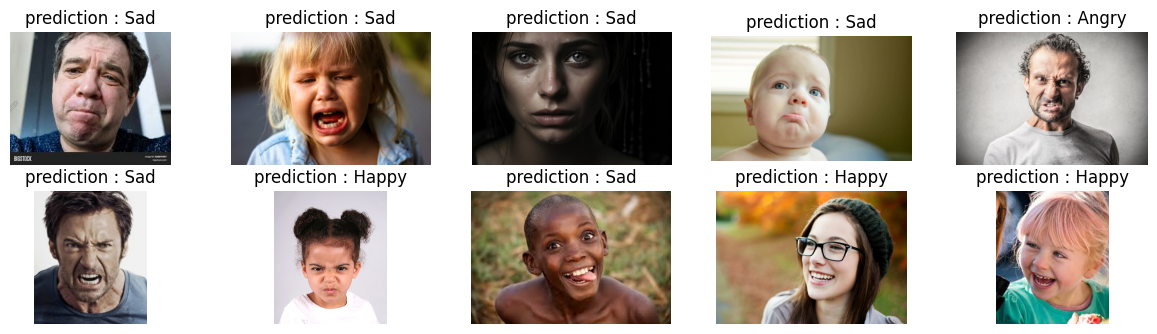

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(len(PATHS)):
  plt.subplot(5, 5, i+1)
  plt.imshow(imgs[i])
  plt.title(f"prediction : {predictions[i]}")
  plt.axis('off')

In [ ]:
predictions = model.predict(val_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
